## Assignment #2 (demo) - Analyzing cardiovascular disease data

Инициализация окружения

In [104]:
# Import all required modules
# Disable warnings
import warnings
import math
import numpy as np
import pandas as pd

warnings.filterwarnings("ignore")

# Import plotting modules and set up
import seaborn as sns
sns.set()
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Tune the visual settings for figures in `seaborn`
sns.set_context(
    "notebook", font_scale=1.5, rc={"figure.figsize": (11, 8), "axes.titlesize": 18}
)

from matplotlib import rcParams

rcParams["figure.figsize"] = 11, 8

### Предварительная разведка
Читаем датасет

In [169]:
DATA_PATH = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/main/data/"
df = pd.read_csv(DATA_PATH + "mlbootcamp5_train.csv", sep=";")
print("Dataset size:", df.shape)
df.info()

Dataset size: (70000, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


Рассмотрим колличество тех или иных категоральных переменных. Для этого преобразуем данные в длинный формат (одна колонка с идентификаторами, другая с измерениями)

Это полезно для реструктуризации данных, особенно перед визуализацией или анализом.

In [23]:
df_uniques = pd.melt(
    frame=df,
    value_vars=["gender", "cholesterol", "gluc", "smoke", "alco", "active", "cardio"]
)
#

,variable,value
0,gender,2
1,gender,1
2,gender,1
3,gender,2
4,gender,1
...,...,...
489995,cardio,0
489996,cardio,1
489997,cardio,1
489998,cardio,1


In [35]:
df_stat = (
    pd.DataFrame(df_uniques.groupby(["variable", "value"])["value"].count()) # групируем по variable и value и добавляем калонку с кол-вом каждого
    .sort_index(level=[0,1])
    .rename(columns={"value": "count"})
    .reset_index()
)
df_stat

,variable,value,count
0,active,0,13739
1,active,1,56261
2,alco,0,66236
3,alco,1,3764
4,cardio,0,35021
5,cardio,1,34979
6,cholesterol,1,52385
7,cholesterol,2,9549
8,cholesterol,3,8066
9,gender,1,45530


([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'active'),
  Text(1, 0, 'alco'),
  Text(2, 0, 'cardio'),
  Text(3, 0, 'cholesterol'),
  Text(4, 0, 'gender'),
  Text(5, 0, 'gluc'),
  Text(6, 0, 'smoke')])

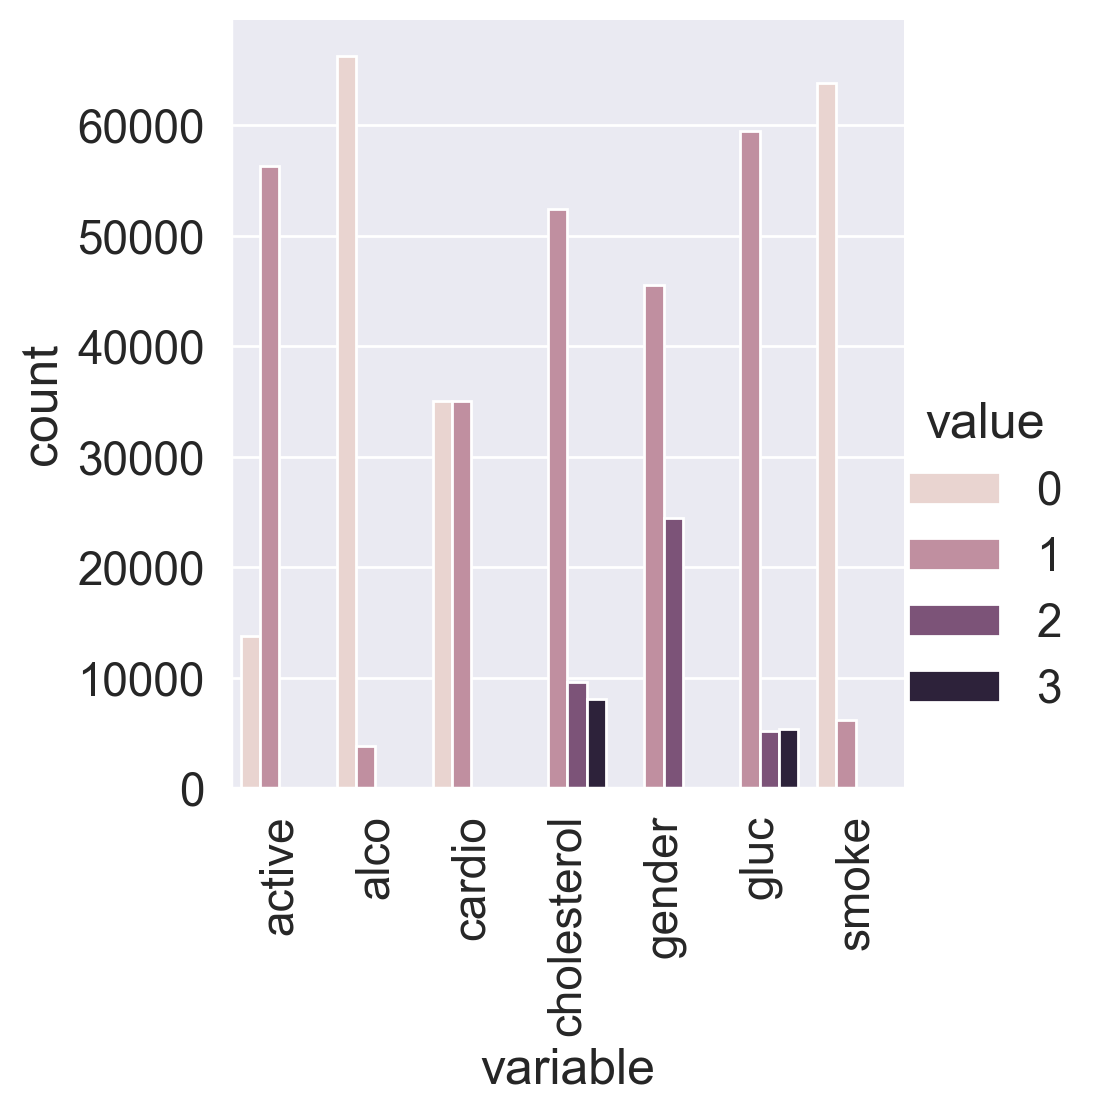

In [40]:
sns.catplot(
    x="variable", y = "count", hue="value", data=df_stat, kind="bar"
)
plt.xticks(rotation='vertical')

Видим, что исследуемый класс `cardio` (наличие заболевания) сбалансирован.

Разобьем на 2 датесет на 2 части.

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'active'),
  Text(1, 0, 'alco'),
  Text(2, 0, 'cholesterol'),
  Text(3, 0, 'gender'),
  Text(4, 0, 'gluc'),
  Text(5, 0, 'smoke')])

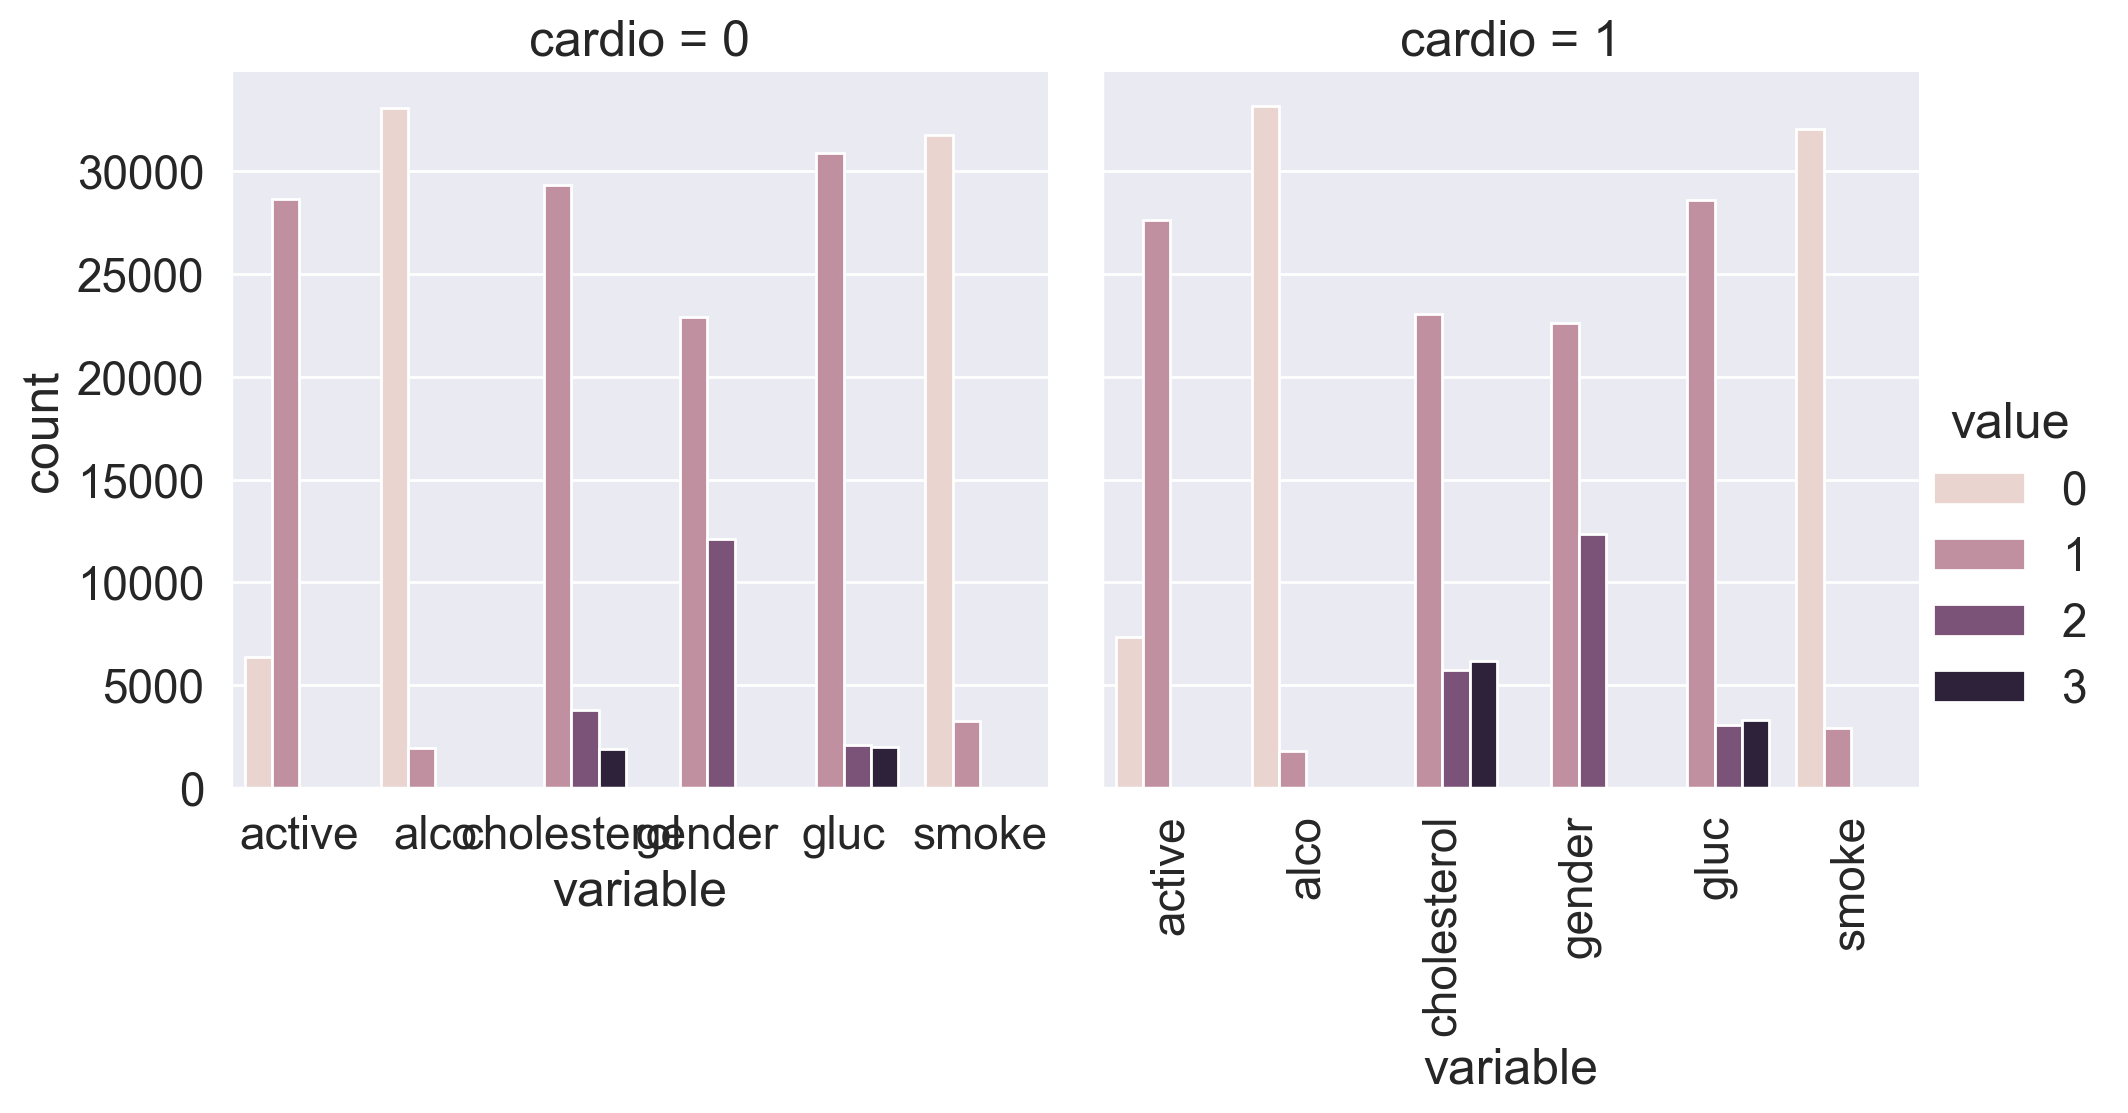

In [57]:
df_uniques = pd.melt(
    frame=df,
    value_vars=["gender", "cholesterol", "gluc", "smoke", "alco", "active", "cardio"],
    id_vars=["cardio"]
)
df_uniques = (
    pd.DataFrame(df_uniques.groupby(["variable", "value", "cardio"])["value"].count())
    .sort_index(level=[0,1])
    .rename(columns={"value": "count"})
    .reset_index()
)

sns.catplot(
    x="variable",
    y="count",
    hue="value",
    col="cardio",
    data=df_uniques,
    kind="bar"
)
plt.xticks(rotation='vertical')

Заметим, что распределение уровня холестерина и глюкозы, сильно разнится при разных значениях рассматриваемой переменной

Подсчитаем некотороые статистики.

In [59]:
for c in df.columns:
    n = df[c].nunique()
    print(c)
    if n < 3:
        print(n, sorted(df[c].value_counts().to_dict().items()))
    else:
        print(n)

    print(10*"-")

id
70000
----------
age
8076
----------
gender
2 [(1, 45530), (2, 24470)]
----------
height
109
----------
weight
287
----------
ap_hi
153
----------
ap_lo
157
----------
cholesterol
3
----------
gluc
3
----------
smoke
2 [(0, 63831), (1, 6169)]
----------
alco
2 [(0, 66236), (1, 3764)]
----------
active
2 [(0, 13739), (1, 56261)]
----------
cardio
2 [(0, 35021), (1, 34979)]
----------


## 1.1. Basic observations

1.1 How many men and women are present in this dataset? Values of the gender feature were not given (whether “1” stands for women or for men) – figure this out by looking analyzing height, making the assumption that men are taller on average.

In [68]:
df.groupby("gender")["height"].mean()
# делаем вывод, что gender 1 - женщины 

gender
1    161.355612
2    169.947895
Name: height, dtype: float64

In [73]:
len(df[df["gender"] == 1]), len(df[df["gender"] == 2])

(45530, 24470)

1.2 Who more often report consuming alcohol – men or women?

In [78]:
df.groupby("gender")["alco"].describe() # => мужчины пьют чаще

,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
1,45530.0,0.025500,0.157639,0.0,0.0,0.0,0.0,1.0
2,24470.0,0.106375,0.308323,0.0,0.0,0.0,0.0,1.0


In [80]:
# Другой способо
df.pivot_table(["alco"], ["gender"], aggfunc="sum")

,alco
gender,
1,1161
2,2603


1.3. What's the rounded difference between the percentages of smokers among men and women?

In [85]:
df[df["gender"] == 2]["smoke"].mean() - df[df["gender"] == 1]["smoke"].mean()

np.float64(0.20102390309976736)

1.4. What's the rounded difference between median values of age (in months) for non-smokers and smokers? You'll need to figure out the units of feature `age` in this dataset.

In [97]:
abs((df[df["smoke"] == 0]["age"].median() / 30.5) - (df[df["smoke"] == 1]["age"].median()/30.5))


np.float64(19.573770491803316)

1.5 Calculate fractions of ill people (with CVD) in the two groups of people described in the task. What’s the ratio of these two fractions?

In [100]:
df["age_years"] = (df["age"] / 365.25).round().astype("int")

smoking_old_men = df[
    (df["gender"] == 2)
    & (df["age_years"] >= 60)
    & (df["age_years"] < 65)
    & (df["smoke"] == 1)
]

In [102]:
smoking_old_men[
    (smoking_old_men["cholesterol"] == 1) & (smoking_old_men["ap_hi"] < 120)
]["cardio"].mean() # 26 процентов старых курящих, с нормальным давлением и низким холестрином 

np.float64(0.2631578947368421)

In [103]:
smoking_old_men[
    (smoking_old_men["cholesterol"] == 3)
    & (smoking_old_men["ap_hi"] >= 160)
    & (smoking_old_men["ap_hi"] < 180)
]["cardio"].mean()

np.float64(0.8636363636363636)

### 1.3. Analyzing BMI

In [105]:
df["BMI"] = df["weight"] / (df["height"] / 100) ** 2 # норма [18.5, 25]

In [106]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,BMI
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50,21.967120
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55,34.927679
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,52,23.507805
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48,28.710479
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,48,23.011177


In [125]:
df.BMI.median() # вне нормы
df[df["gender"] == 1]["BMI"].mean(), df[df["gender"] == 2]["BMI"].mean() # правда
df.pivot_table(["BMI"], ["cardio"], aggfunc="median") # ложь

df.groupby(["gender", "alco", "cardio"])["BMI"].median().to_frame()

BMI
gender alco cardio           
1      0    0       25.654372
            1       27.885187
       1    0       27.885187
            1       30.110991
2      0    0       25.102391
            1       26.674874
       1    0       25.351541
            1       27.530797

### 1.4. Cleaning data

In [129]:
before = len(df)
# чистим данные
df_to_remove = df[
    (df["ap_lo"] > df["ap_hi"])
    | (df["height"] < df["height"].quantile(0.025))
    | (df["height"] > df["height"].quantile(0.975))
    | (df["weight"] < df["weight"].quantile(0.025))
    | (df["weight"] > df["weight"].quantile(0.975))
]
print(df_to_remove.shape[0] / df.shape[0])

filtered_df = df[~df.index.isin(df_to_remove)]


0.0963


## Part 2. Visual data analysis

### 2.1. Correlation matrix visualization
Построим матрицу корреляций.

<Axes: >

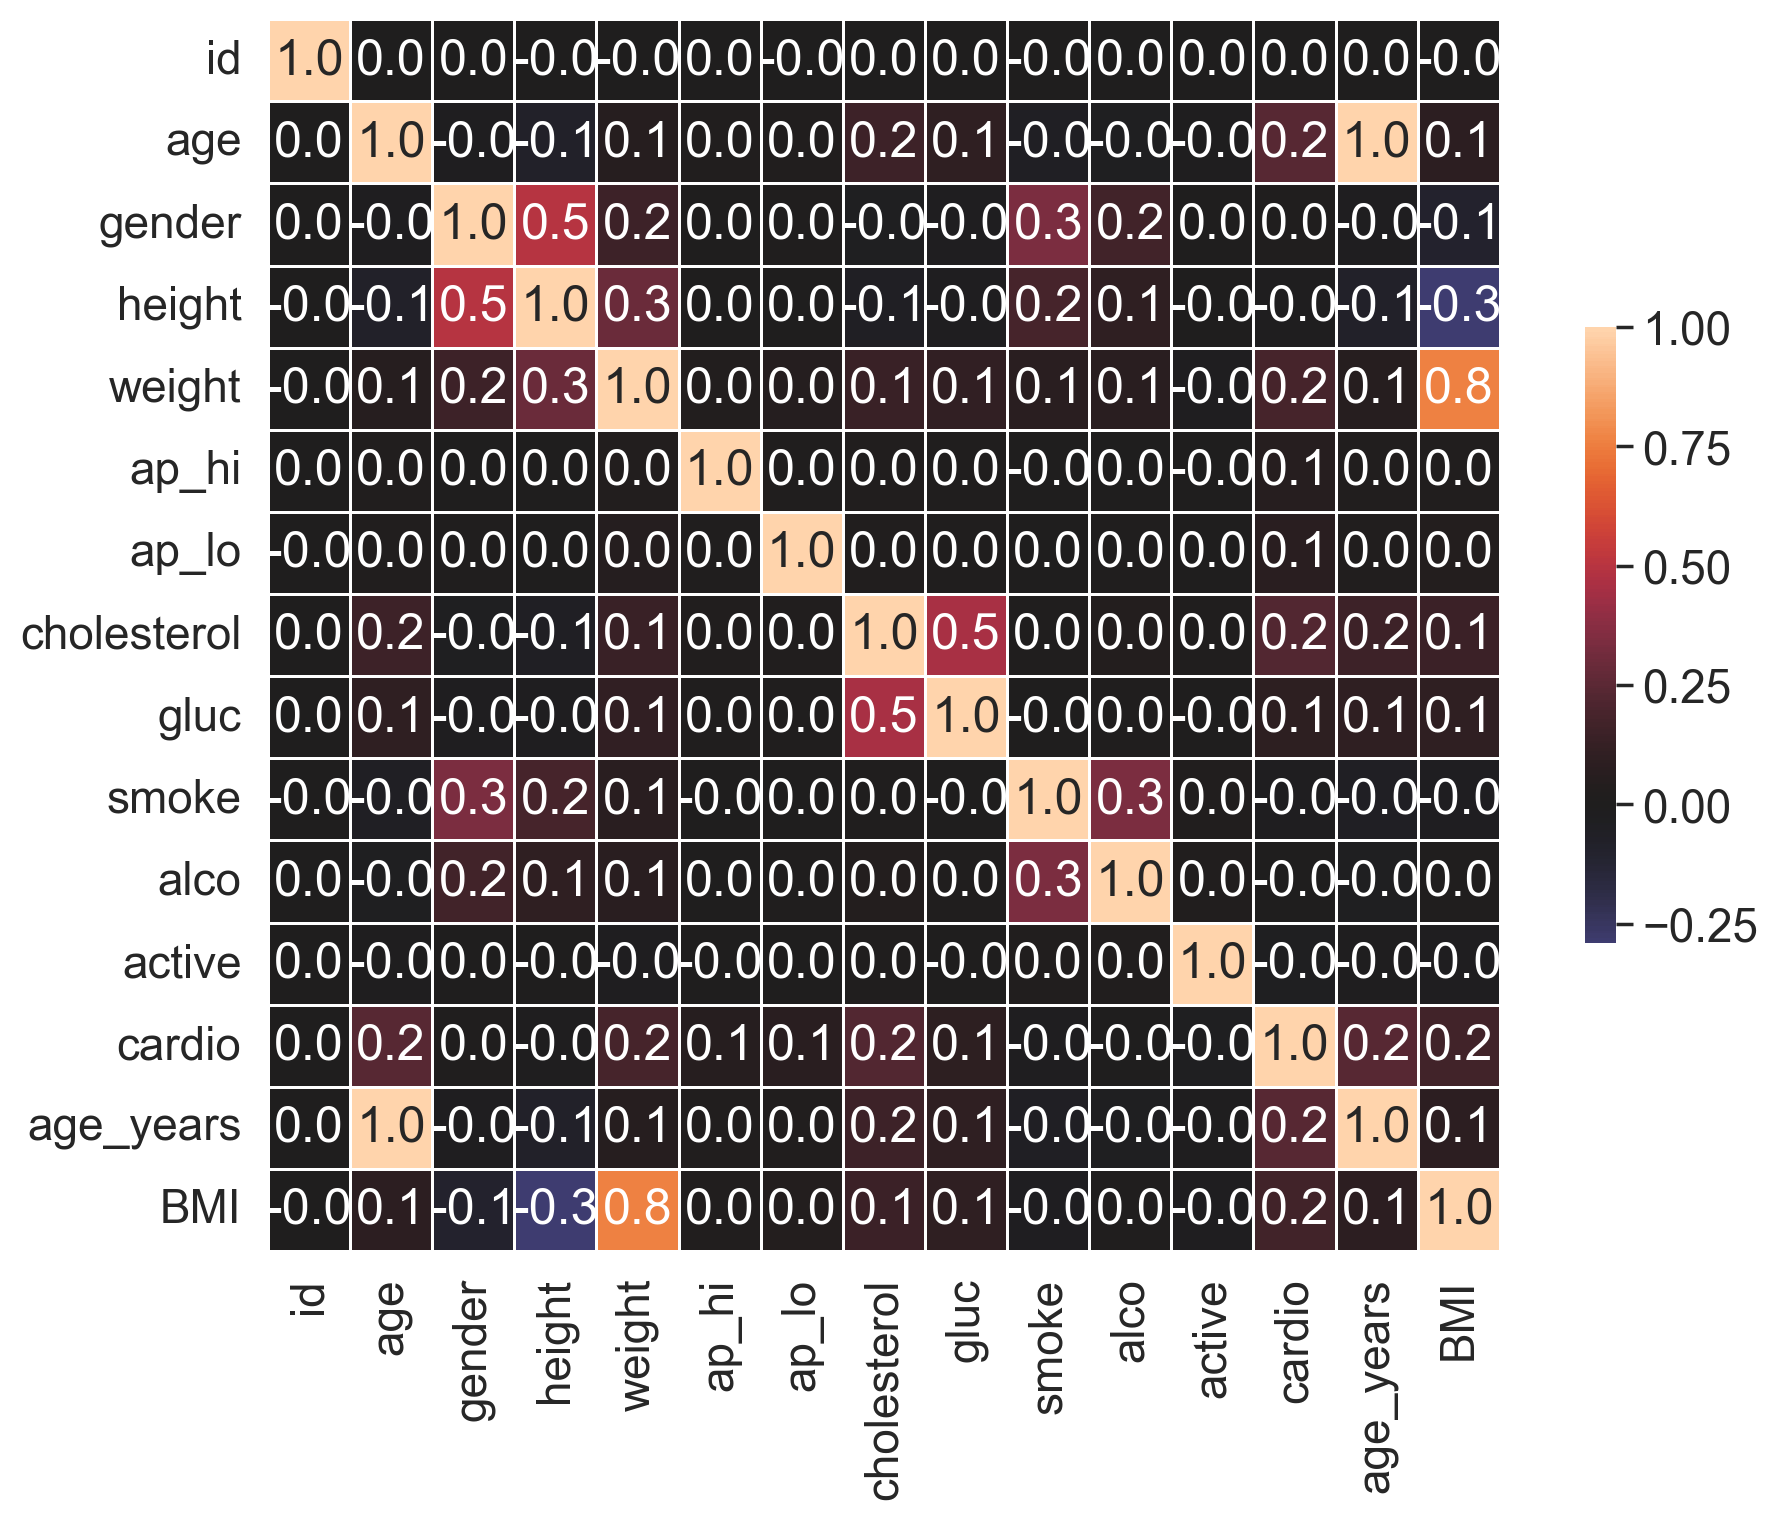

In [175]:
corr = filtered_df.corr(method='pearson')

sns.heatmap(corr, annot=True, fmt=".1f", linewidths=.5, vmax=1, center=0, square=True, cbar_kws={"shrink": 0.5})

### 2.2. Height distribution of men and women

<Axes: xlabel='variable', ylabel='value'>

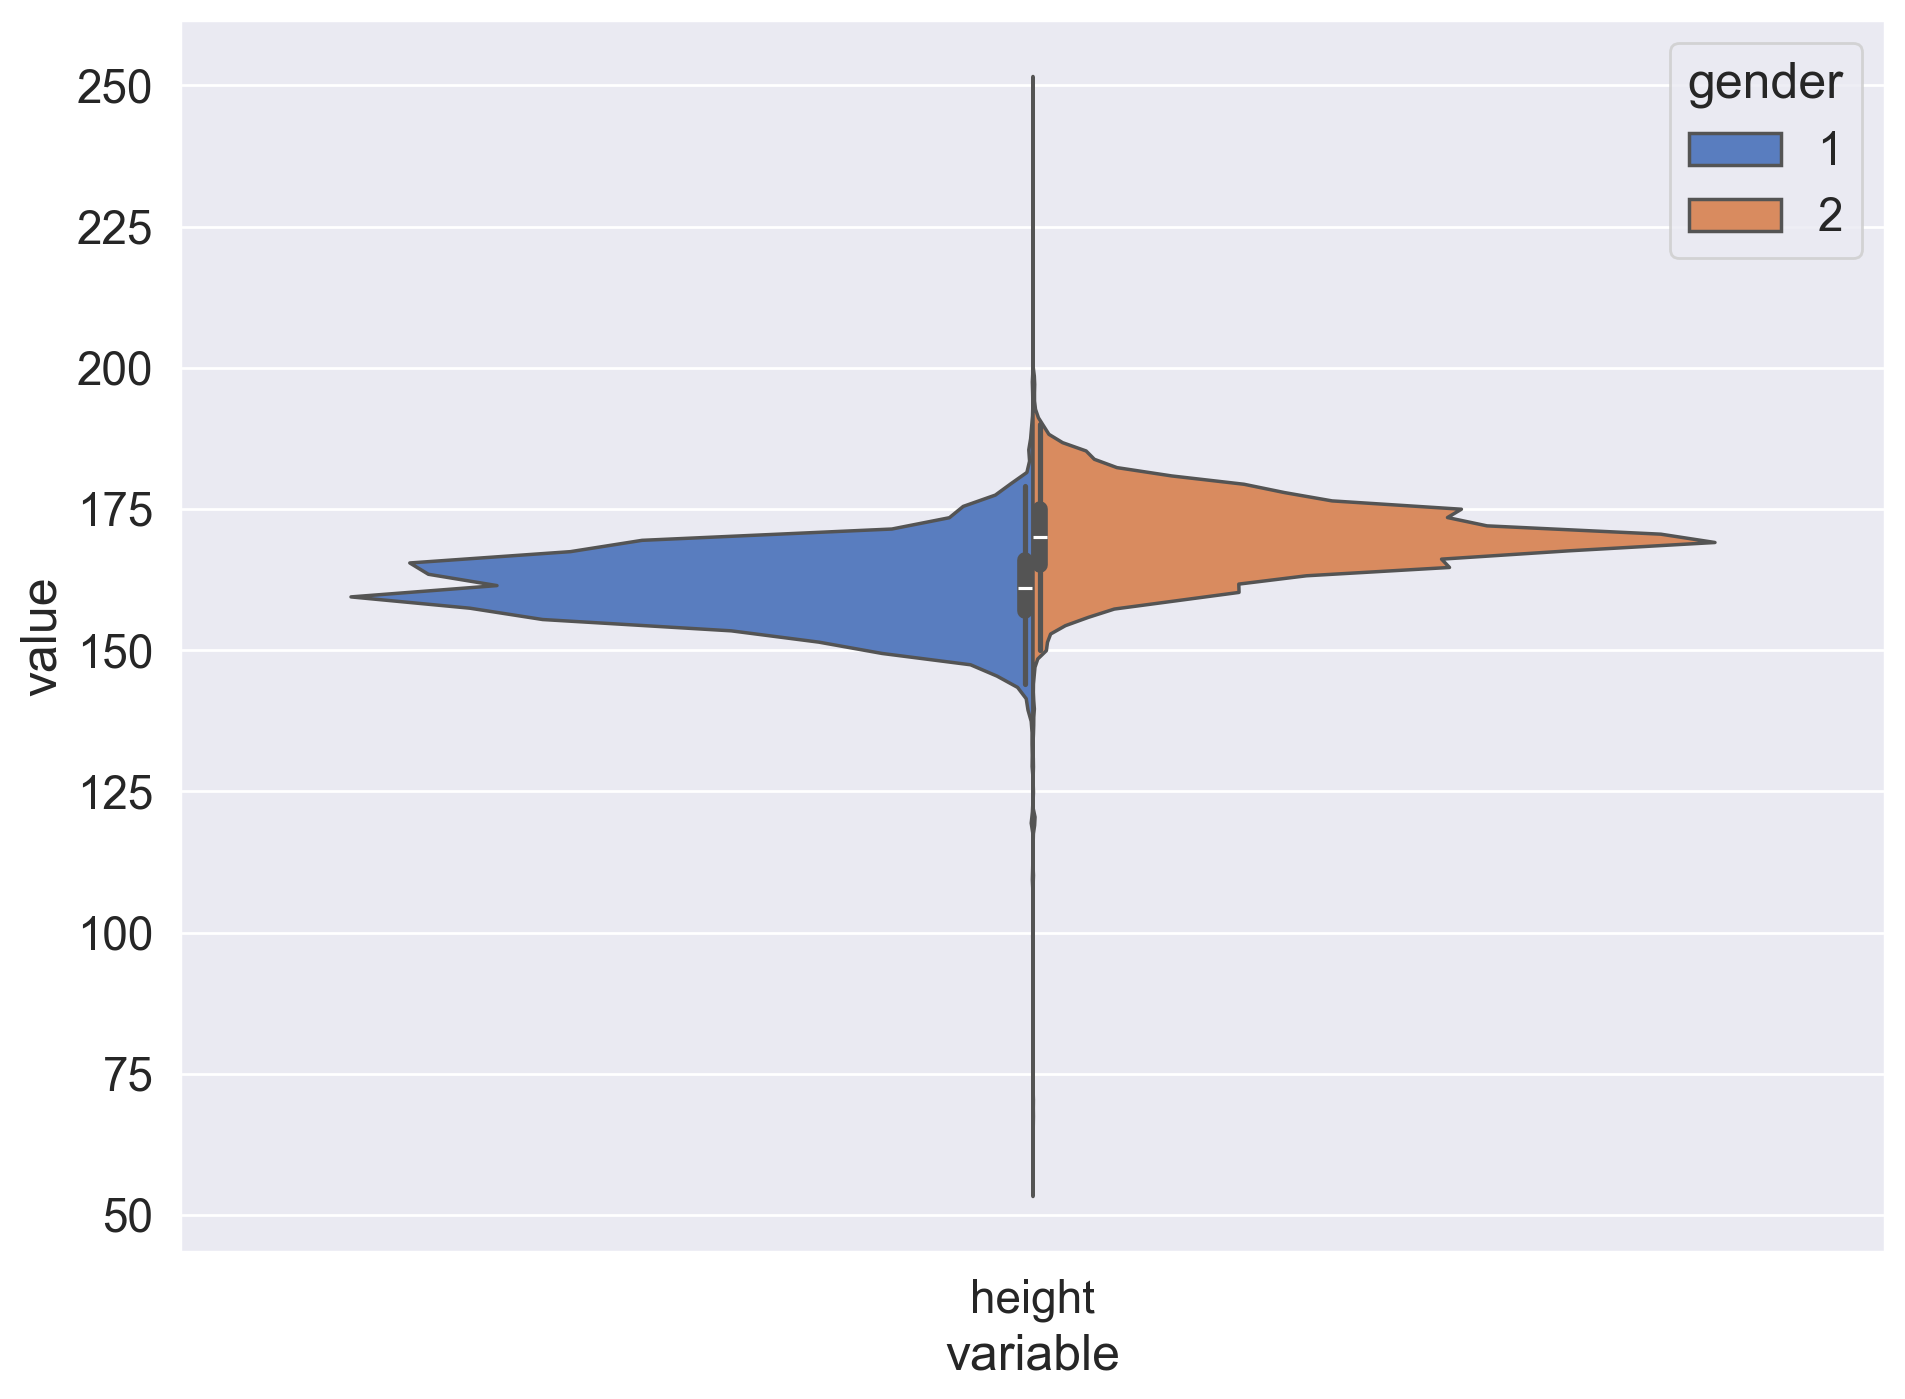

In [161]:
df_long = pd.melt(filtered_df, value_vars=["height"], id_vars='gender')
df_long
sns.violinplot(x='variable', y='value', hue="gender",palette="muted", split=True, data=df_long, scale="count", scale_hue=False)


### 2.3. Rank correlation
rank correlation - поможет нам выявить такие пары признаков, в которых более низкий ранг в вариационном ряду одного признака всегда предшествует более высокому рангу в другом (а в случае отрицательной корреляции мы имеем обратное).

Calculate and plot a correlation matrix using the Spearman’s rank correlation coefficient.

Коэффициент ранговой корреляции **Спирмена** (Spearman's rank correlation coefficient) — это статистическая мера, которая оценивает зависимость между двумя переменными на основе их рангов. Он показывает, насколько хорошо зависимости между переменными можно описать монотонной функцией (не обязательно линейной).

<Axes: >

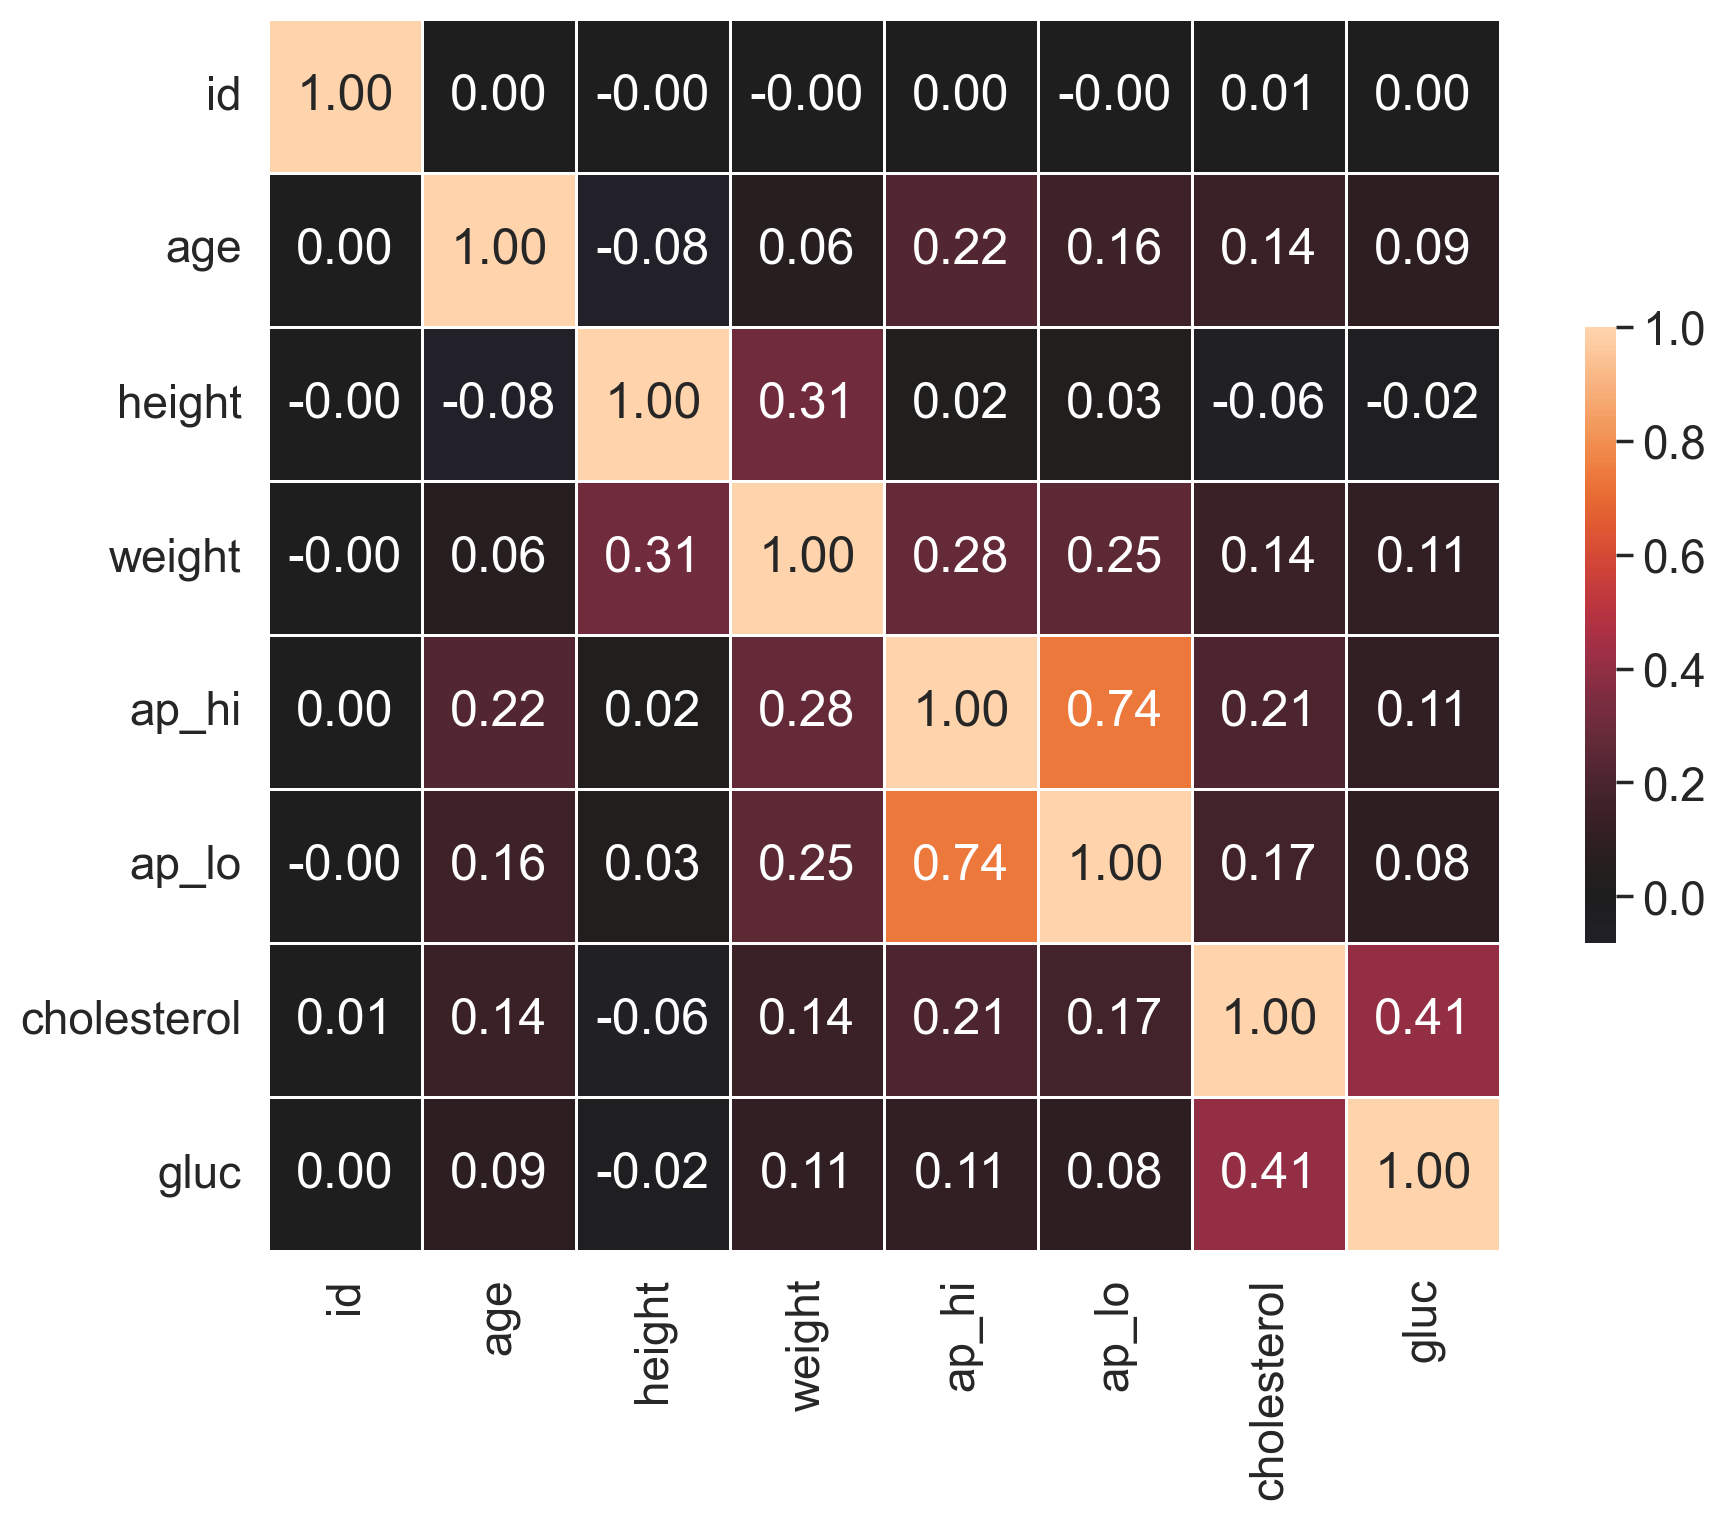

In [179]:
corr = df[["id", "age", "height", "weight", "ap_hi", "ap_lo", "cholesterol", "gluc"]].corr(method='spearman')

sns.heatmap(corr, annot=True, fmt=".2f", linewidths=.5, vmax=1, center=0, square=True, cbar_kws={"shrink": 0.5})

### 2.4. Age

<Axes: xlabel='age_years', ylabel='count'>

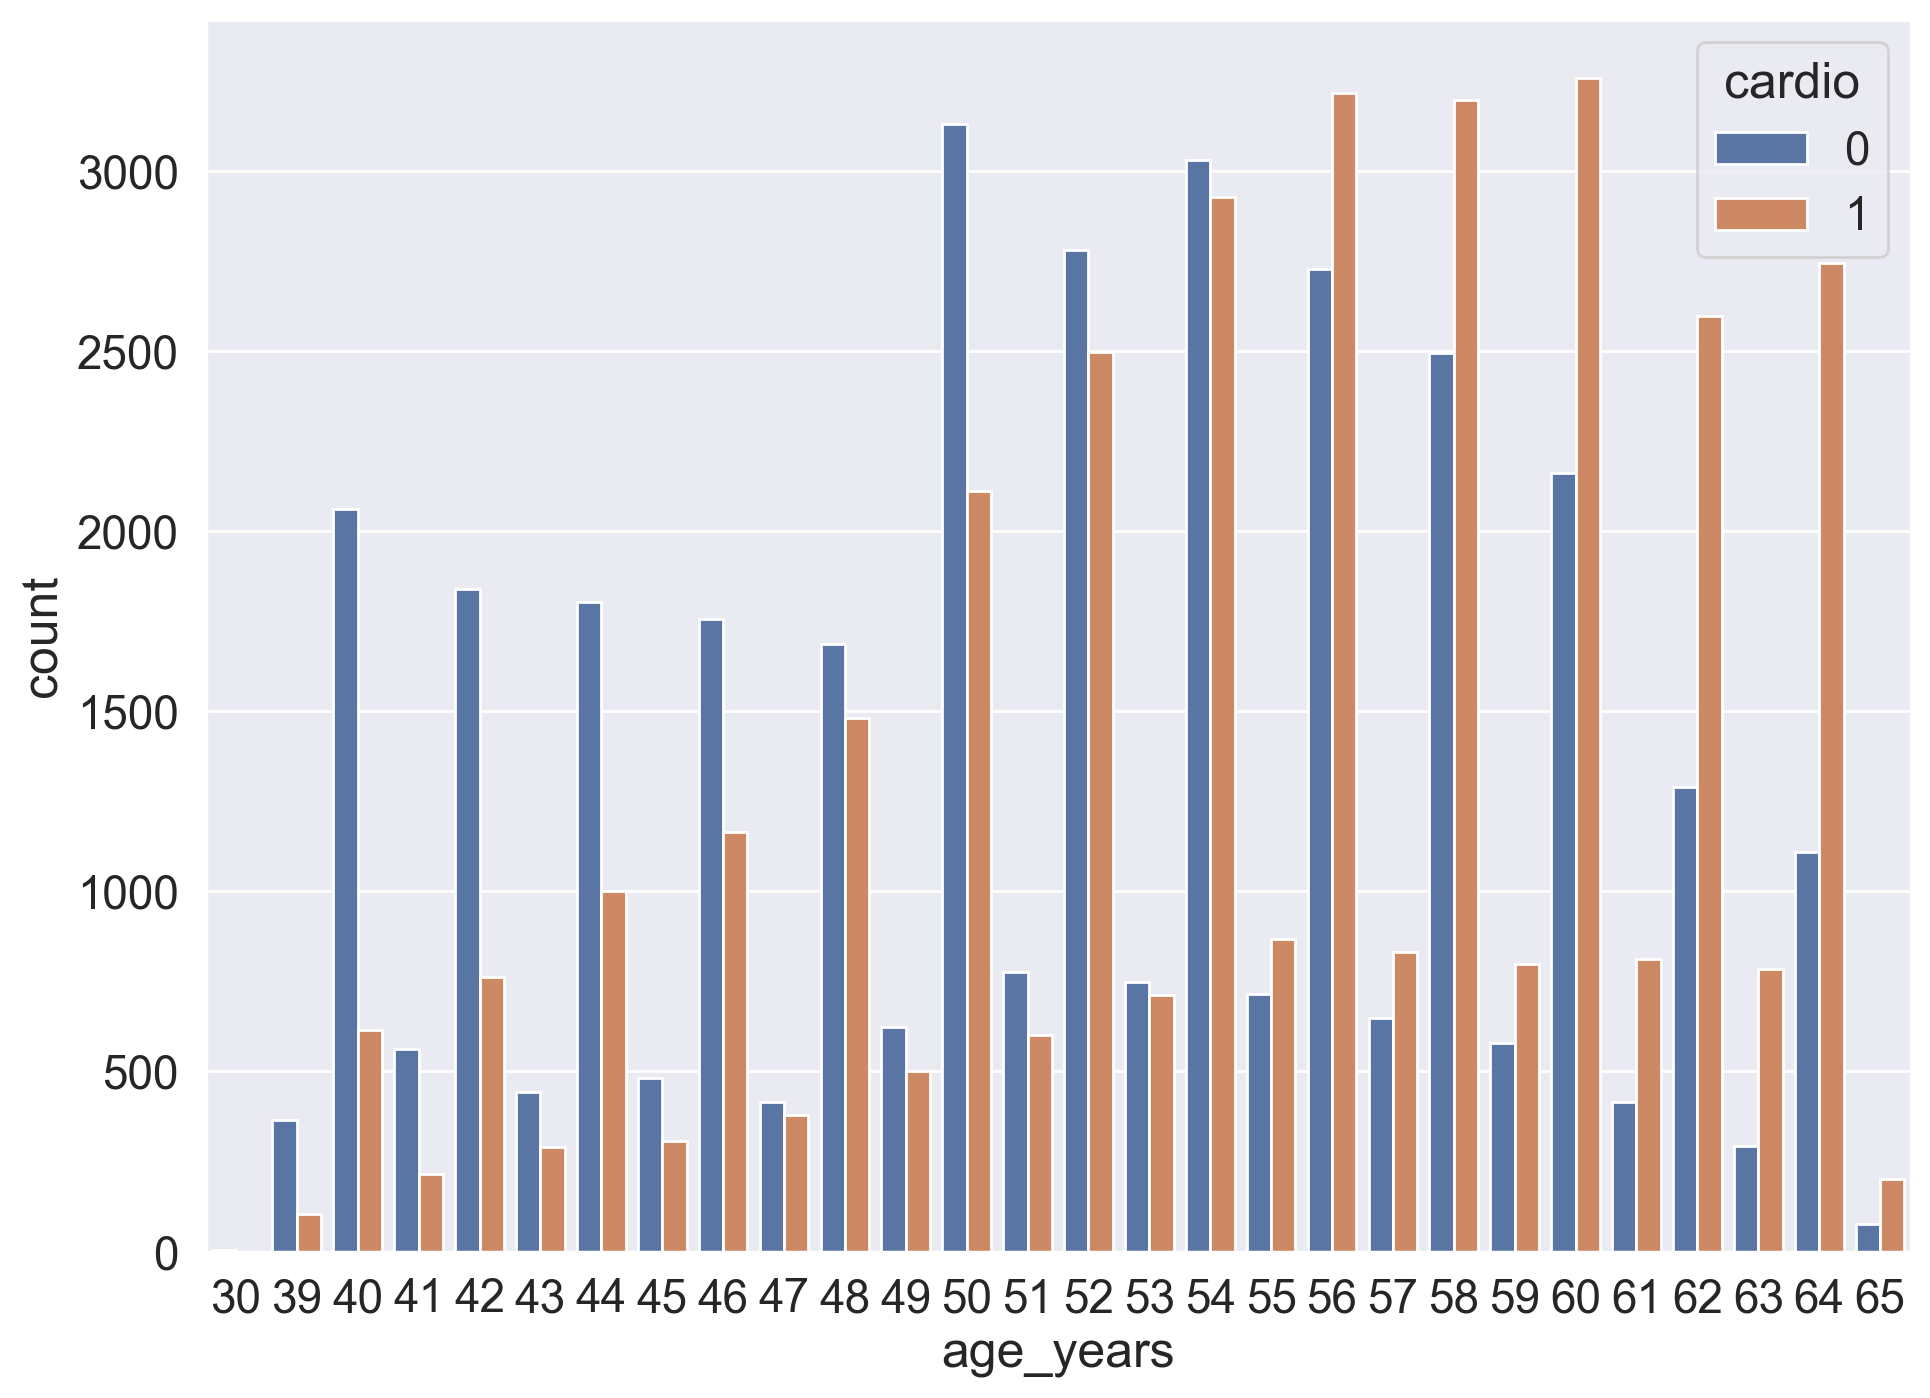

In [184]:
sns.countplot(data=filtered_df, x='age_years', hue='cardio')